In [4]:
from pathlib import Path
import subprocess

In [19]:
in_dir = Path('data/internal/alphafold/casp14')
out_dir = Path('data/processed/dssp_alphafold')
out_dir.mkdir(exist_ok=True)
for iso_dir in in_dir.iterdir():
    cmd = 'mkdssp -i {} -o {}'.format(iso_dir / 'ranked_0.pdb',
                                      out_dir / (iso_dir.stem + '.dssp'))
    ret = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if ret.returncode != 0:
        print(cmd)
        print(ret.stderr)
        print(ret.stderr)

mkdssp -i data/internal/alphafold/casp14/E4F1-1/ranked_0.pdb -o data/processed/dssp_alphafold/E4F1-1.dssp
b'DSSP could not be created due to an error:\nNo such file\n'
b'DSSP could not be created due to an error:\nNo such file\n'
mkdssp -i data/internal/alphafold/casp14/ZNF655-2/ranked_0.pdb -o data/processed/dssp_alphafold/ZNF655-2.dssp
b'DSSP could not be created due to an error:\nNo such file\n'
b'DSSP could not be created due to an error:\nNo such file\n'
mkdssp -i data/internal/alphafold/casp14/ZNF772-1/ranked_0.pdb -o data/processed/dssp_alphafold/ZNF772-1.dssp
b'DSSP could not be created due to an error:\nNo such file\n'
b'DSSP could not be created due to an error:\nNo such file\n'
mkdssp -i data/internal/alphafold/casp14/SOX15-2/ranked_0.pdb -o data/processed/dssp_alphafold/SOX15-2.dssp
b'DSSP could not be created due to an error:\nNo such file\n'
b'DSSP could not be created due to an error:\nNo such file\n'
mkdssp -i data/internal/alphafold/casp14/ZNF341-2/ranked_0.pdb -o data

In [1]:
from Bio.PDB.DSSP import make_dssp_dict
import pandas as pd


In [2]:
from Bio.Data.IUPACData import protein_letters_3to1

In [9]:
dssp_dir = Path('data/processed/dssp_alphafold')
dfs = []
for dssp_file_path in dssp_dir.iterdir():
    dssp = make_dssp_dict(dssp_file_path)
    dfs.append(pd.DataFrame(data=[(dssp_file_path.stem, k[1][1], v[0], v[1], v[2]) for k, v in dssp[0].items()],
                      columns=['clone_name', 'position', 'aa', 'secondary_structure', 'ASA']))
df = pd.concat(dfs, axis=0, ignore_index=True)
# NOTE: the Davey analysis uses GGXGG whereas I think this paper is GXG
# Wilke: Tien et al. 2013 https://doi.org/10.1371/journal.pone.0080635
max_asa = {
        "ALA": 129.0,
        "ARG": 274.0,
        "ASN": 195.0,
        "ASP": 193.0,
        "CYS": 167.0,
        "GLN": 225.0,
        "GLU": 223.0,
        "GLY": 104.0,
        "HIS": 224.0,
        "ILE": 197.0,
        "LEU": 201.0,
        "LYS": 236.0,
        "MET": 224.0,
        "PHE": 240.0,
        "PRO": 159.0,
        "SER": 155.0,
        "THR": 172.0,
        "TRP": 285.0,
        "TYR": 263.0,
        "VAL": 174.0,
    }
max_asa = {protein_letters_3to1[k.capitalize()]: v for k, v in max_asa.items()}
df['RSA'] = df['ASA'] / df['aa'].map(max_asa)
df['RSA'] = df['RSA'].clip(upper=1.)
WINDOW_SIZE_RESIDUES = 20
DISORDER_WINDOW_RSA_CUTOFF = 0.5
rsa_window_col = f'RSA_window_{WINDOW_SIZE_RESIDUES}'
"""
df[rsa_window_col] = (
    df['RSA'].rolling(window=WINDOW_SIZE_RESIDUES * 2 + 1,
                  min_periods=WINDOW_SIZE_RESIDUES + 1,
                  center=True)
             .mean())
"""
df[rsa_window_col] = (
         df.groupby('clone_name')['RSA']
           .rolling(window=WINDOW_SIZE_RESIDUES * 2 + 1,
                  min_periods=WINDOW_SIZE_RESIDUES + 1,
                  center=True)
             .mean().rename(rsa_window_col).droplevel('clone_name')
)
df['is_disordered'] = df[rsa_window_col] >= DISORDER_WINDOW_RSA_CUTOFF

In [7]:
df['secondary_structure'].value_counts()

-    151527
H     75987
T     20315
E     17677
S     15462
G      4997
B       910
I       682
Name: secondary_structure, dtype: int64

In [13]:
list(range(20, 10, -1))

10

In [41]:
# add the helix thing
DISORDER_HELIX_LENGTH_CUTOFF = 20
to_change = []
for clone_name, df_clone in df.groupby('clone_name'):
    helix_count = 0
    for _i, row in df_clone.iterrows():
        if row['secondary_structure'] == 'H':
            helix_count += 1
        else:
            if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
                for i in range(row['position'] - 1, row['position'] - helix_count, -1):
                    to_change.append((clone_name, i))
            helix_count = 0
    if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
        for i in range(row['position'], row['position'] - helix_count, -1):
            to_change.append((clone_name, i))
to_change = (df['clone_name'] + '_' + df['position'].astype(str)).isin({a + '_' + str(b) for a, b in to_change})
print(f'{to_change.sum()} ({to_change.mean():.0%}) aa in helices of length 20 aa or more')
print(f"{df.loc[to_change, 'is_disordered'].mean():.0%} of residues in long helices misclassified as disordered")
df.loc[to_change, 'is_disordered'] = False

In [56]:
df.to_csv('data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
          index=False, sep='\t')

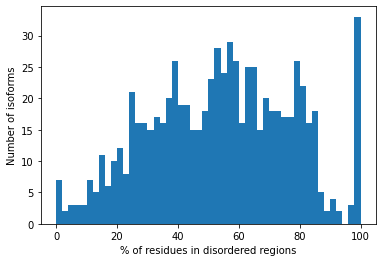

In [57]:
# plot disordered fraction of isoforms
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
f_dis = df.groupby('clone_name')['is_disordered'].mean()
(f_dis * 100).plot.hist(range=(0, 100), bins=50, ax=ax)
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('% of residues in disordered regions')
fig.savefig('figures/disordered-residued-pct-per-isoform_TFiso1_histogram.pdf', bbox_inches='tight')

Text(0, 0.5, '% residues in disordered regions')

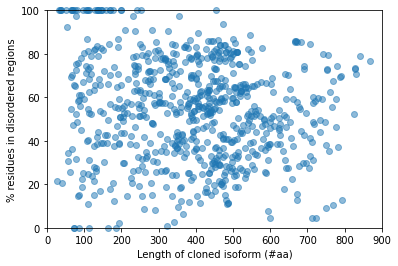

In [68]:
# TODO: color by family
# TODO: split by reference and alternative isoforms
fig, ax = plt.subplots(1, 1)
ax.scatter(df.groupby('clone_name').size(), 
           df.groupby('clone_name')['is_disordered'].mean() * 100,
           clip_on=False,
           alpha=0.5)
ax.set_ylim(0, 100)
ax.set_xlim(0, 900)
ax.set_xlabel('Length of cloned isoform (#aa)')
ax.set_ylabel('% residues in disordered regions')

In [ ]:
# plots of length of disordered sequence?

In [ ]:
# comparison of reference to alternative isoforms


In [ ]:
# pairwise metrics of disorder/order
# - number of ordered residues different
# - number of disordered residues different

In [75]:
# lazy version: delta disordered residues
# for each isoform: number of residues, disordered residues and ordered residues
# for each pair, delta of all
n_aa = df.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = df.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']

,n_aa,n_aa_disordered,n_aa_ordered
clone_name,,,
AEBP2-2,268,88.0,180.0
AEBP2-3,263,179.0,84.0
ARNT2-1,717,342.0,375.0
ARNT2-2,683,303.0,380.0
ARNT2-3,716,348.0,368.0
...,...,...,...
ZSCAN26-2,344,131.0,213.0
ZSCAN32-2,624,286.0,338.0
ZSCAN32-4,215,124.0,91.0


In [129]:
f_dis.sort_values()

clone_name
ZNF415-4    0.0
ZNF415-3    0.0
TBPL1-1     0.0
ZBTB25-4    0.0
KLF7-6      0.0
           ... 
ZNF696-2    1.0
ZNF23-3     1.0
ZNF175-3    1.0
ZNF772-4    1.0
DLX5-2      1.0
Name: is_disordered, Length: 742, dtype: float64